In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from scipy.signal import butter, filtfilt

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from adan_pytorch import Adan

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from IPython.display import clear_output

In [2]:
PATH = "/home/gromov_n/MASS/ss2/"

### Loading and preprocess data

In [3]:
def ReadSignals():
    all_data = {}
    for file in tqdm(os.listdir(PATH)):
        if "PSG" in file:
            data = mne.io.read_raw_edf(PATH + file, verbose=False)
            raw_data = data.get_data()

            labels = np.load("data/" + file + "labels.npy")
            assert len(labels) == len(raw_data[0])
            number = int(file[8:10])
            all_data[number] = [raw_data, labels]
           
            data.close()
    return all_data

In [4]:
all_data = ReadSignals()
assert len(all_data) == 19

100%|██████████████████████████████████████████████████████| 97/97 [01:36<00:00,  1.00it/s]


Тест и невалидные данные (из статьи)

In [5]:
IDS_INVALID = [4, 8, 15, 16]  # Only 1 expert 
IDS_TEST = [13, 12, 2, 6]

In [6]:
def broad_filter(signal, fs, lowcut=0.1, highcut=35):
    """Returns filtered signal sampled at fs Hz, with a [lowcut, highcut] Hz
    bandpass."""
    # Generate butter bandpass of order 3.
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(3, (low, high), btype='band')
    # Apply filter to the signal with zero-phase.
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

In [7]:
for key, values in tqdm(all_data.items()):
    if key in IDS_TEST:
        print(key)

100%|██████████████████████████████████████████████████| 19/19 [00:00<00:00, 251393.62it/s]

12
6
2
13


In [8]:
train_data = []
train_labels = []

test_data = []
test_labels = []

for key, values in tqdm(all_data.items()):
    if key in IDS_TEST:
        test_data.append(broad_filter(values[0], 256))
        test_labels.append(values[1])
    elif key not in IDS_INVALID:
        train_data.append(broad_filter(values[0], 256))
        train_labels.append(values[1])
assert len(train_data) == 11
assert len(test_data) == 4     

100%|██████████████████████████████████████████████████████| 19/19 [01:08<00:00,  3.59s/it]


In [9]:
signal = train_data[0]
means = signal.mean(axis = 1)[..., None]
stds = signal.std(axis = 1)[..., None]

norm_signal = (signal - means) / stds

In [10]:
np.quantile(norm_signal, q=[0.25, 0.99])

array([-0.3324036 ,  2.82031343])

In [11]:
def NormalizeAndClip(data):
    for i in tqdm(range(len(data))):
        signal = data[i]
        means = signal.mean(axis=1)[..., None]
        stds = signal.std(axis=1)[..., None]
        signal = np.clip((signal - means) / stds, a_min=-10, a_max=10)
        data[i] = signal

In [12]:
NormalizeAndClip(train_data)
NormalizeAndClip(test_data)

100%|████████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.52s/it]


In [13]:
#np.save("data/all_train", train_data)
#np.save("data/all_test", test_data)

In [14]:
#train_cpy = np.load("data/all_train.npy")

In [15]:
for i in range(len(train_data)):
    train_data[i] = torch.FloatTensor(train_data[i])#.to("cuda")
    new_trainl = torch.zeros(2, len(train_labels[i]))
    new_trainl = (torch.arange(2) == torch.LongTensor(train_labels[i])[:,None]).T
    new_trainl = new_trainl.float()
    train_labels[i] = new_trainl#.to("cuda")

for i in range(len(test_data)):
    test_data[i] = torch.FloatTensor(test_data[i])#.to("cuda")
    new_testl = torch.zeros(2, len(test_labels[i]))
    new_testl = (torch.arange(2) == torch.LongTensor(test_labels[i])[:,None]).T
    new_testl = new_testl.float()
    test_labels[i] = new_testl#.to("cuda")

In [16]:
s = 0
lens = 0
for i in range(len(train_data)):
    s += train_labels[i][1].sum()
    lens += len(train_labels[i][1])
print(s / lens)

s = 0
lens = 0
for i in range(len(test_data)):
    s += test_labels[i][1].sum()
    lens += len(test_labels[i][1])

print(s / lens)

tensor(0.0625)
tensor(0.0556)


In [17]:
RECEPTIVE_FIELD = 4000
OVERLAP = 520 # now is 0 should test 520

def CreateSamples(x, labels, rf = RECEPTIVE_FIELD, ov = OVERLAP):
    inout_seq = []
    L = x.shape[-1]
    for i in tqdm(range(ov, L- rf - ov, rf)):
        train_seq = x[:, i-ov:i+rf+ov]
        train_label = labels[:, i:i+rf]
        inout_seq.append((train_seq ,train_label))
    return inout_seq
    

In [18]:
train_samples = []
for i in range(len(train_data)):
    train_samples += CreateSamples(train_data[i], train_labels[i])

test_samples_seed = []
test_samples_unet = []
for i in range(len(test_data)):
    test_samples_seed += CreateSamples(test_data[i], test_labels[i])
    test_samples_unet += CreateSamples(test_data[i], test_labels[i], ov=0)    

100%|████████████████████████████████| 2327/2327 [00:00<00:00, 127695.44it/s]


In [19]:
train_dataloader = DataLoader(train_samples, batch_size=120, shuffle=True, drop_last=True) 
test_dataloader_seed = DataLoader(test_samples_seed, batch_size=120, shuffle=False, drop_last=True)
test_dataloader_unet = DataLoader(test_samples_unet, batch_size=120, shuffle=False, drop_last=True)

### Network

In [20]:
class MDB_block(nn.Module):
    def __init__(self, k, F):
        super(MDB_block, self).__init__()

        #print(F, k)
        self.conv11 = nn.Conv1d(F, F//2, kernel_size=k, dilation=1, padding=(k-1)//2) #p = d * (k-1) / 2
        self.bn11 = nn.BatchNorm1d(F//2)
        self.conv12 = nn.Conv1d(F, F//4, kernel_size=k, dilation=2, padding=k-1) 
        self.bn12 = nn.BatchNorm1d(F//4)
        self.conv13 = nn.Conv1d(F, F//8, kernel_size=k, dilation=4, padding=2*(k-1))
        self.bn13 = nn.BatchNorm1d(F//8)
        self.conv14 = nn.Conv1d(F, F//8, kernel_size=k, dilation=8, padding=4*(k-1))
        self.bn14 = nn.BatchNorm1d(F//8)

        self.conv21 = nn.Conv1d(F//2, F//2, kernel_size=k, dilation=1, padding=(k-1)//2)
        self.bn21 = nn.BatchNorm1d(F//2)
        self.conv22 = nn.Conv1d(F//4, F//4, kernel_size=k, dilation=2, padding=k-1)
        self.bn22 = nn.BatchNorm1d(F//4)
        self.conv23 = nn.Conv1d(F//8, F//8, kernel_size=k, dilation=4, padding=2*(k-1))
        self.bn23 = nn.BatchNorm1d(F//8)
        self.conv24 = nn.Conv1d(F//8, F//8, kernel_size=k, dilation=8, padding=4*(k-1))
        self.bn24 = nn.BatchNorm1d(F//8)

        self.relu = nn.ReLU()

        
    
    def forward(self,x):

        x1 = self.conv11(x)
        x1 = self.bn11(x1)
        x1 = self.relu(x1)
        x1 = self.conv21(x1)
        x1 = self.bn21(x1)
        x1 = self.relu(x1)
        
        x2 = self.conv12(x)
        x2 = self.bn12(x2)
        x2 = self.relu(x2)
        x2 = self.conv22(x2)
        x2 = self.bn22(x2)
        x2 = self.relu(x2)

        x3 = self.conv13(x)
        x3 = self.bn13(x3)
        x3 = self.relu(x3)
        x3 = self.conv23(x3)
        x3 = self.bn23(x3)
        x3 = self.relu(x3)

        x4 = self.conv14(x)
        x4 = self.bn14(x4)
        x4 = self.relu(x4)
        x4 = self.conv24(x4)
        x4 = self.bn24(x4)
        x4 = self.relu(x4)
        #print("x1", x1.size())
        #print("x2", x2.size())
        #print("x3", x3.size())
        #print("x4", x4.size())
        
        return torch.concatenate([x1, x2, x3, x4], axis=1)  

class SEED(nn.Module):
    def __init__(self, overlap=0, input_dim=27, F = 64, q1=0.2, q2=0.5, N1=256, N2=128):
        super(SEED, self).__init__()

        self.N1 = N1
        
        self.bn = nn.BatchNorm1d(input_dim)
        self.conv1 = nn.Conv1d(input_dim, F, kernel_size=3, padding = 520 - overlap)
        self.bn1 = nn.BatchNorm1d(F)
        self.relu = nn.ReLU()
        
        self.conv2 = nn.Conv1d(F, 2*F, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(2*F)

        self.AvgPool1D = nn.AvgPool1d(2)

        self.mdb1 = MDB_block(3, 2*F)

        self.conv3 = nn.Conv1d(2*F, 4*F, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(4*F)
        
        self.mdb2 = MDB_block(3, 4*F)

        self.dropout1 = nn.Dropout(q1)
        self.dropout2 = nn.Dropout(q2)

        
        self.lstm1 = nn.LSTM(N1, N1, num_layers=1, batch_first=True, bidirectional=True)
        self.convlstm1 = nn.Conv1d(2*N1, N1, kernel_size=1) #256?
        self.bn3 = nn.BatchNorm1d(N1)

        self.lstm2 = nn.LSTM(N1, N1, num_layers=1, batch_first=True, bidirectional=True)
        self.convlstm2 = nn.Conv1d(2*N1, N1, kernel_size=1) #256?
        self.bn4 = nn.BatchNorm1d(N1)

        self.classifier1 = nn.Conv1d(N1, N2, kernel_size=1) 
        self.bn5 = nn.BatchNorm1d(N2)
        self.classifier2 = nn.Conv1d(N2, 2, kernel_size=1) 

        self.upsample = nn.Upsample(scale_factor=8, mode='nearest')

    def forward(self,x):
        x = self.bn(x)
        x = self.conv1(x)
        #print("conv1", x.size())
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        #print("conv2", x.size())
        
        x = self.bn2(x)
        x = self.relu(x)

        x = self.AvgPool1D(x)
        #print("AvgPool1D1", x.size())
        
        x = self.mdb1(x)
        #print("mdb1", x.size())

        x = self.conv3(x)
        #print("conv3", x.size())
        
        x = self.bn3(x)
        x = self.relu(x)

        x = self.AvgPool1D(x)
        #print("AvgPool1D2", x.size())
        
        x = self.mdb2(x)
        
        #print("mdb2", x.size())

        x = self.AvgPool1D(x)
        #print("AvgPool1D3", x.size())

        x = x[:, :, 65:-64]
        #print("x crop", x.size())

        x = self.dropout1(x)

        lstm_out, (h_n, c_n) = self.lstm1(x.transpose(2, 1))

        #print("lstm_out1", lstm_out.size())

        x = lstm_out[:, :, :self.N1] + lstm_out[:, :, self.N1:]
        x = self.dropout2(x)

        #print("x.size()", x.size())

        lstm_out, (h_n, c_n) = self.lstm2(x)

        #print("lstm_out2", lstm_out.size())

        x = lstm_out[:, :, :self.N1] + lstm_out[:, :, self.N1:]
        x = self.dropout2(x)
        #print("x.size()", x.size())
        x = x.transpose(2, 1)
        x = self.dropout2(x)
        #print("x.size()", x.size())

        x = self.classifier1(x)
        #print("class1", x.size())
        
        x = self.bn5(x)
        x = self.relu(x)

        x = self.classifier2(x)    
        #print("class2", x.size())

        x =self.upsample(x)    
        #print("upsample", x.size())
    
        return x
        
        
        

In [21]:
class conbr_block(nn.Module):
    def __init__(self, in_layer, out_layer, kernel_size, stride, dilation):
        super(conbr_block, self).__init__()

        self.conv1 = nn.Conv1d(in_layer, out_layer, kernel_size=kernel_size, stride=stride, dilation = dilation, padding = 3, bias=True)
        self.bn = nn.BatchNorm1d(out_layer)
        self.relu = nn.ReLU()
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.bn(x)
        out = self.relu(x)
        
        return out       

class se_block(nn.Module):
    def __init__(self,in_layer, out_layer):
        super(se_block, self).__init__()
        
        self.conv1 = nn.Conv1d(in_layer, out_layer//8, kernel_size=1, padding=0)
        self.conv2 = nn.Conv1d(out_layer//8, in_layer, kernel_size=1, padding=0)
        self.fc = nn.Linear(1,out_layer//8)
        self.fc2 = nn.Linear(out_layer//8,out_layer)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self,x):

        x_se = nn.functional.adaptive_avg_pool1d(x,1)
        x_se = self.conv1(x_se)
        x_se = self.relu(x_se)
        x_se = self.conv2(x_se)
        x_se = self.sigmoid(x_se)
        
        x_out = torch.add(x, x_se)
        return x_out

class re_block(nn.Module):
    def __init__(self, in_layer, out_layer, kernel_size, dilation):
        super(re_block, self).__init__()
        
        self.cbr1 = conbr_block(in_layer,out_layer, kernel_size, 1, dilation)
        self.cbr2 = conbr_block(out_layer,out_layer, kernel_size, 1, dilation)
        self.seblock = se_block(out_layer, out_layer)
    
    def forward(self,x):

        x_re = self.cbr1(x)
        x_re = self.cbr2(x_re)
        x_re = self.seblock(x_re)
        x_out = torch.add(x, x_re)
        return x_out          

class UNET_1D(nn.Module):
    def __init__(self ,input_dim,layer_n,kernel_size,depth):
        super(UNET_1D, self).__init__()
        self.input_dim = input_dim
        self.layer_n = layer_n
        self.kernel_size = kernel_size
        self.depth = depth
        
        self.AvgPool1D1 = nn.AvgPool1d(input_dim, stride=5, padding=12)
        self.AvgPool1D2 = nn.AvgPool1d(input_dim, stride=25, padding=8)
        self.AvgPool1D3 = nn.AvgPool1d(input_dim, stride=125, padding=8)
        
        self.layer1 = self.down_layer(self.input_dim, self.layer_n, self.kernel_size,1, 2)
        self.layer2 = self.down_layer(self.layer_n, int(self.layer_n*2), self.kernel_size,5, 2)
        self.layer3 = self.down_layer(int(self.layer_n*2)+int(self.input_dim), int(self.layer_n*3), self.kernel_size,5, 2)
        self.layer4 = self.down_layer(int(self.layer_n*3)+int(self.input_dim), int(self.layer_n*4), self.kernel_size,5, 2)
        self.layer5 = self.down_layer(int(self.layer_n*4)+int(self.input_dim), int(self.layer_n*5), self.kernel_size,4, 2)

        self.cbr_up1 = conbr_block(int(self.layer_n*7), int(self.layer_n*3), self.kernel_size, 1, 1)
        self.cbr_up2 = conbr_block(int(self.layer_n*5), int(self.layer_n*2), self.kernel_size, 1, 1)
        self.cbr_up3 = conbr_block(int(self.layer_n*3), self.layer_n, self.kernel_size, 1, 1)
        self.upsample = nn.Upsample(scale_factor=5, mode='nearest')
        self.upsample1 = nn.Upsample(scale_factor=5, mode='nearest') #for 4000 it is 5 and for 100 is 4
        
        self.outcov = nn.Conv1d(self.layer_n, 2, kernel_size=self.kernel_size, stride=1,padding = 3)
    
        
    def down_layer(self, input_layer, out_layer, kernel, stride, depth):
        block = []
        block.append(conbr_block(input_layer, out_layer, kernel, stride, 1))
        for i in range(depth):
            block.append(re_block(out_layer,out_layer,kernel,1))
        return nn.Sequential(*block)
            
    def forward(self, x):
        
        #print("x", x.size())
        pool_x1 = self.AvgPool1D1(x)
        #print("pool_x1", pool_x1.size())
        
        pool_x2 = self.AvgPool1D2(x)
        #print("pool_x2", pool_x2.size())
        
        pool_x3 = self.AvgPool1D3(x)
        #print("pool_x3", pool_x3.size())
        
        
        #############Encoder#####################
        
        out_0 = self.layer1(x)
        #print("out_0", out_0.size())
        out_1 = self.layer2(out_0)        
        #print("out_1", out_1.size())
        
        
        x = torch.cat([out_1,pool_x1],1)

        #print("x", x.size())
        out_2 = self.layer3(x)
        #print("out_2", out_2.size())
        
        x = torch.cat([out_2,pool_x2],1)
        #print("x", x.size())
        x = self.layer4(x)
        #print("x", x.size())
        
        
        #############Decoder####################
        
        up = self.upsample1(x)
        #print("up", up.size())
        
        up = torch.cat([up,out_2],1)
        #print("up", up.size())
        
        up = self.cbr_up1(up)
        #print("up", up.size())
        
        up = self.upsample(up)
        #print("up", up.size())
        
        up = torch.cat([up,out_1],1)
        #print("up", up.size())
        
        up = self.cbr_up2(up)
        #print("up", up.size())
        
        
        up = self.upsample(up)
        #print("up", up.size())
        
        up = torch.cat([up,out_0],1)
        #print("up", up.size())
        
        up = self.cbr_up3(up)
        #print("up", up.size())
        
        out = self.outcov(up)
        #print("out", out.size())
        
        #out = nn.functional.softmax(out,dim=2)
        
        return out

In [22]:
#test_input100 = torch.FloatTensor(np.ones((32, 27, 4000)))

In [23]:
model1 = SEED(overlap=520).to("cuda")
#model(test_input100)

In [24]:
model2 = UNET_1D(27,128,7,3) #(input_dim, hidden_layer, kernel_size, depth)
model2 = model2.to("cuda")

### Collecting predicts

In [32]:
#torch.save(model.state_dict(), "./models/4000SEED2_520OverlapADANNoEarlyStop226Epochs")

In [25]:
model1.load_state_dict(torch.load("./models/4000SEED2_520Overlap"))

<All keys matched successfully>

In [26]:
model2.load_state_dict(torch.load("./models/4000UnetADANNoEarlyStop"))

<All keys matched successfully>

In [27]:
def CollectingPreds(model, data):

    model.eval()
    model.cpu()
    all_preds = []
    for i in range(len(data)):
        record_preds = []
        for idx in tqdm(range(OVERLAP, data[i].size()[1]- RECEPTIVE_FIELD - OVERLAP, RECEPTIVE_FIELD)):

            train_seq = data[i][:, idx-OVERLAP:idx+RECEPTIVE_FIELD+OVERLAP][None, ...]
            out = model(train_seq)
            m = nn.Softmax(dim=1)
            out = m(out)
            
            preds = out.detach().cpu().numpy()
            record_preds.append(preds.transpose(0, 2, 1))
        shapes = np.array(record_preds).shape
        record_preds = np.array(record_preds).reshape(shapes[0] * shapes[1] * shapes[2], 2)
        all_preds.append(record_preds)
    return all_preds

In [59]:
OVERLAP = 520
all_preds_seed = CollectingPreds(model1)
OVERLAP = 0
all_preds_unet = CollectingPreds(model2)


100%|████████████████████████████████████| 1627/1627 [01:25<00:00, 19.08it/s]


(1627, 1, 4000, 2)


100%|████████████████████████████████████| 1852/1852 [01:36<00:00, 19.29it/s]


(1852, 1, 4000, 2)


100%|████████████████████████████████████| 1999/1999 [01:41<00:00, 19.67it/s]


(1999, 1, 4000, 2)


100%|████████████████████████████████████| 1659/1659 [01:24<00:00, 19.62it/s]


(1659, 1, 4000, 2)


100%|████████████████████████████████████| 1688/1688 [01:27<00:00, 19.32it/s]


(1688, 1, 4000, 2)


100%|████████████████████████████████████| 1811/1811 [01:33<00:00, 19.44it/s]


(1811, 1, 4000, 2)


100%|████████████████████████████████████| 2352/2352 [01:59<00:00, 19.73it/s]


(2352, 1, 4000, 2)


100%|████████████████████████████████████| 1803/1803 [01:31<00:00, 19.67it/s]


(1803, 1, 4000, 2)


100%|████████████████████████████████████| 1891/1891 [01:37<00:00, 19.46it/s]


(1891, 1, 4000, 2)


100%|████████████████████████████████████| 1909/1909 [01:38<00:00, 19.40it/s]


(1909, 1, 4000, 2)


100%|████████████████████████████████████| 1813/1813 [01:31<00:00, 19.90it/s]


(1813, 1, 4000, 2)


100%|████████████████████████████████████| 1627/1627 [01:37<00:00, 16.69it/s]


(1627, 1, 4000, 2)


100%|████████████████████████████████████| 1853/1853 [01:51<00:00, 16.66it/s]


(1853, 1, 4000, 2)


100%|████████████████████████████████████| 1999/1999 [01:59<00:00, 16.72it/s]


(1999, 1, 4000, 2)


100%|████████████████████████████████████| 1659/1659 [01:39<00:00, 16.75it/s]


(1659, 1, 4000, 2)


100%|████████████████████████████████████| 1689/1689 [01:40<00:00, 16.82it/s]


(1689, 1, 4000, 2)


100%|████████████████████████████████████| 1811/1811 [01:47<00:00, 16.79it/s]


(1811, 1, 4000, 2)


100%|████████████████████████████████████| 2352/2352 [02:20<00:00, 16.76it/s]


(2352, 1, 4000, 2)


100%|████████████████████████████████████| 1803/1803 [01:46<00:00, 16.86it/s]


(1803, 1, 4000, 2)


100%|████████████████████████████████████| 1891/1891 [01:52<00:00, 16.82it/s]


(1891, 1, 4000, 2)


100%|████████████████████████████████████| 1909/1909 [01:53<00:00, 16.84it/s]


(1909, 1, 4000, 2)


100%|████████████████████████████████████| 1813/1813 [01:47<00:00, 16.87it/s]


(1813, 1, 4000, 2)


In [28]:
OVERLAP = 520
all_preds_seed_test = CollectingPreds(model1, test_data)
OVERLAP = 0
all_preds_unet_test = CollectingPreds(model2, test_data)


100%|████████████████████████████████████| 2327/2327 [02:16<00:00, 17.10it/s]


In [61]:
# for i in range(len(all_preds_seed)):
#     np.save("data/EnsembleData/SEED" + str(i), all_preds_seed[i])
#     np.save("data/EnsembleData/UNET" + str(i), all_preds_unet[i])    

In [29]:
# for i in range(len(all_preds_seed_test)):
#     np.save("data/EnsembleData/SEED_test" + str(i), all_preds_seed_test[i])
#     np.save("data/EnsembleData/UNET_test" + str(i), all_preds_unet_test[i])    

In [16]:
all_preds_seed = []
all_preds_unet = []

for i in range(len(train_labels)):
    all_preds_seed.append(np.load("data/EnsembleData/SEED" + str(i) + ".npy"))
    all_preds_unet.append(np.load("data/EnsembleData/UNET" + str(i) + ".npy"))
    
    

In [17]:
all_preds_seed_test = []
all_preds_unet_test = []

for i in range(len(test_labels)):
    all_preds_seed_test.append(np.load("data/EnsembleData/SEED_test" + str(i) + ".npy"))
    all_preds_unet_test.append(np.load("data/EnsembleData/UNET_test" + str(i) + ".npy"))
    
    

In [18]:
ensemble_seed_train = []
ensemble_unet_train = []
ensemble_train_labels = []
for i in range(len(train_labels)):
    pred_len = min(all_preds_seed[i].shape[0], all_preds_unet[i][520:].shape[0])    
    ensemble_seed_train.append(all_preds_seed[i][:pred_len])
    ensemble_unet_train.append(all_preds_unet[i][520:pred_len+520])
    ensemble_train_labels.append(train_labels[i][:, 520:pred_len+520])
    
ensemble_seed_test = []
ensemble_unet_test = []
ensemble_test_labels = []
for i in range(len(test_labels)):
    pred_len = min(all_preds_seed_test[i].shape[0], all_preds_unet_test[i][520:].shape[0])
    ensemble_seed_test.append(all_preds_seed_test[i][:pred_len])
    ensemble_unet_test.append(all_preds_unet_test[i][520:pred_len+520])
    ensemble_test_labels.append(test_labels[i][:, 520:pred_len+520]) 

In [19]:
def CreateSamplesEnsemble(x1, x2, labels):
    inout_seq = []
    L = x1.shape[0]
    for i in tqdm(range(L)):
        train_seq = np.concatenate((x1[i], x2[i]))
        train_label = labels[:, i]
        inout_seq.append((train_seq ,train_label))
    return inout_seq
    

In [20]:
ensemble_train_samples = []
for i in range(len(ensemble_seed_train)):
    ensemble_train_samples += CreateSamplesEnsemble(ensemble_seed_train[i], ensemble_unet_train[i], ensemble_train_labels[i])

ensemble_test_samples = []
for i in range(len(ensemble_seed_test)):
    ensemble_test_samples += CreateSamplesEnsemble(ensemble_seed_test[i], ensemble_unet_test[i], ensemble_test_labels[i])  

100%|█████████████████████████████████████████| 9307480/9307480 [01:52<00:00, 82514.68it/s]


In [21]:
ensemble_train_dataloader = DataLoader(ensemble_train_samples, batch_size=4000*256, shuffle=True, drop_last=True) 
ensemble_test_dataloader = DataLoader(ensemble_test_samples, batch_size=4000*256, shuffle=False, drop_last=True)


In [68]:
classifier = nn.Sequential(
          nn.Linear(4, 8),
          nn.ReLU(),
          nn.Linear(8, 2),
        )
classifier.to("cuda")

# classifier = nn.Sequential(
#           nn.Linear(4, 2)
#         )
# classifier.to("cuda")




Sequential(
  (0): Linear(in_features=4, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=2, bias=True)
)

In [23]:
def run_epoch(model, optimizer, criterion, dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in tqdm(enumerate(dataloader)):
        if is_training:
            optimizer.zero_grad()
      
        #print("x", x.shape)
        
        #print(x.size())
        out = model(x.to("cuda"))
        #print("y", y.shape)
        #print("out", out.shape)
        loss = criterion(out, y.to("cuda"))

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / len(dataloader))


    return epoch_loss

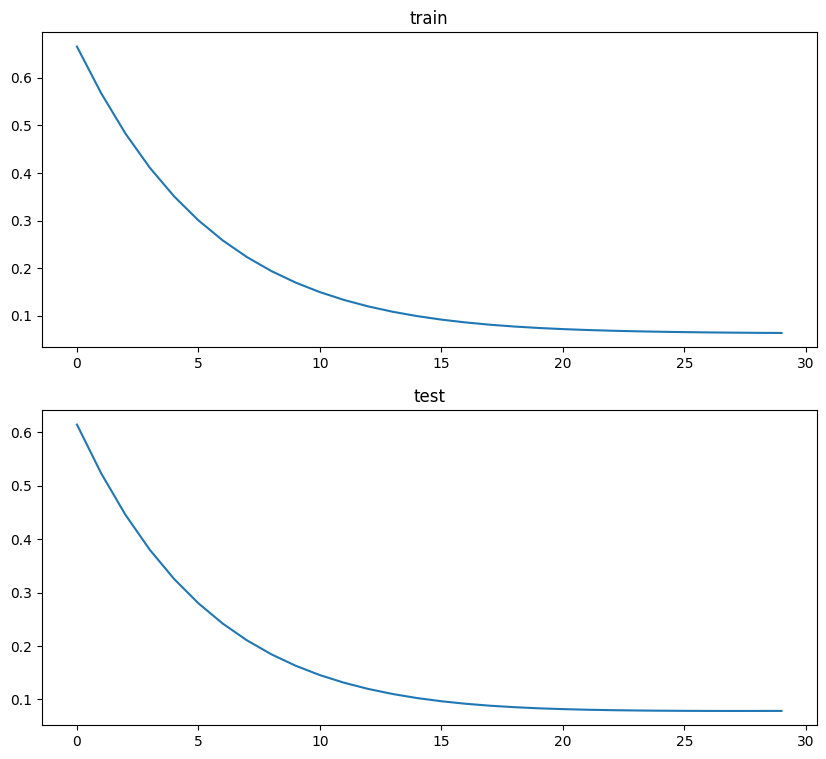

Epoch[30/1000] | loss train:0.064210, test:0.078477


55it [10:37, 11.60s/it]


KeyboardInterrupt: 

In [24]:
# define optimizer and loss function

criterion = nn.BCEWithLogitsLoss()#pos_weight = torch.FloatTensor([[0.3, 0.7]] * 4000).T.to("cuda"))
optimizer = Adan(
    classifier.parameters(),
    lr = 1e-3,                  # learning rate (can be much higher than Adam, up to 5-10x)
    betas = (0.02, 0.08, 0.01), # beta 1-2-3 as described in paper - author says most sensitive to beta3 tuning
    weight_decay = 0.02         # weight decay 0.02 is optimal per author
)

#optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-9)
scheduler = ReduceLROnPlateau(optimizer, patience = 3, factor=0.5, min_lr=0.0001)
epochs = 1000

losses_train = []
losses_test = []
best_loss = 10e9
# begin training

early_stop_count = 30
current_es = 0
for epoch in range(epochs): 
    
        
    loss_train = run_epoch(classifier, optimizer, criterion, ensemble_train_dataloader, is_training=True)
    loss_val = run_epoch(classifier, optimizer, criterion, ensemble_test_dataloader)
    scheduler.step(loss_val)
    losses_train.append(loss_train)
    losses_test.append(loss_val)

    if losses_test[-1] < best_loss:
        current_es = 0
        best_loss = losses_test[-1]
        torch.save(classifier.state_dict(), "./models/EnsembleClassifierShort")
    else:
        current_es += 1
    #if current_es == early_stop_count:
        #break

    clear_output(True)
    fig = plt.figure(figsize=(10, 9))

    ax_1 = fig.add_subplot(2, 1, 1)
    ax_2 = fig.add_subplot(2, 1, 2)
    ax_1.set_title('train')
    ax_1.plot(losses_train)
    ax_2.set_title('test')
    ax_2.plot(losses_test)
    plt.show()


    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f}'
              .format(epoch+1, epochs, loss_train, loss_val))

In [69]:
classifier.load_state_dict(torch.load("./models/EnsembleClassifier"))

<All keys matched successfully>

In [70]:
def CollectingEnsemblePreds(model, seed_preds, unet_preds):

    model.eval()
    model.cpu()
    all_preds = []
    for i in range(len(seed_preds)):
        concat_preds = np.concatenate((seed_preds[i], unet_preds[i]), axis=1)
        out = model(torch.FloatTensor(concat_preds))
        m = nn.Softmax(dim=1)
        out = m(out)
        preds = np.argmax(out.detach().cpu().numpy(), axis=1)        
        all_preds.append(preds)
    return all_preds

In [71]:
all_preds = CollectingEnsemblePreds(classifier, ensemble_seed_test, ensemble_unet_test)

In [72]:
for i in range(4):
    np.save("predicts/Ensemble/Classifier" + str(i), all_preds[i])

In [27]:
in_event = False
c = 0
lens = []
for i in range(len(test_labels[0][1].cpu())):
    
    if test_labels[0][1][i] == 1:
        in_event = True
        c += 1
    elif in_event:
        lens.append(c)
        c = 0
        in_event = False
        

(array([187., 431., 336., 173.,  69.,  29.,  16.,   2.,   1.,   2.]),
 array([  51. ,  168.9,  286.8,  404.7,  522.6,  640.5,  758.4,  876.3,
         994.2, 1112.1, 1230. ]),
 <BarContainer object of 10 artists>)

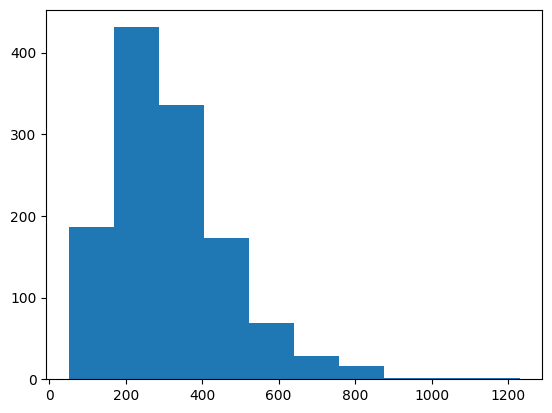

In [33]:
plt.hist(lens)

In [34]:
def MergeClose(predictions, threshold):
    i = 0
    in_event = False
    while i < len(predictions):
        while i < len(predictions) and predictions[i] == 1:
            in_event = True
            i += 1
        if  i < len(predictions) and in_event:
            if np.any(predictions[i:i+threshold]):
                while  i < len(predictions) and predictions[i] == 0:
                    predictions[i] = 1
                    i += 1
            else:
                in_event = False
        i += 1

def DeleteShortEvents(predictions, threshold):
    i = 0
    while i < len(predictions):
        event_len = 0
        event_idx_start = i
        while i < len(predictions) and predictions[i] == 1:
            i += 1
            event_len += 1
        if event_len < threshold:
            predictions[event_idx_start:i] = 0
        i += 1
def PostProcessing(predictions, threshold):
    MergeClose(predictions, threshold)
    DeleteShortEvents(predictions, threshold)

In [73]:
threshold = 30
for i in range(4):
    PostProcessing(all_preds[i], threshold)

### Results

#### Raw labels

In [28]:
def GetRawMetricsAndCM(predictions, test_labels):
    lens = []
    sums = []

    acc = []
    precision = []
    recall = []
    f1 = []
    
    all_cm = 0
    for i in range(len(test_labels)):
        pred_len = len(predictions[i])
        lens.append(pred_len)
        sums.append((predictions[i] == test_labels[i][1, :pred_len].numpy()).sum())      

        acc.append(sums[i] / lens[i])
        precision.append(precision_score(test_labels[i][1, :pred_len].numpy(), predictions[i]))
        recall.append(recall_score(test_labels[i][1, :pred_len].numpy(), predictions[i]))
        f1.append(f1_score(test_labels[i][1, :pred_len].numpy(), predictions[i]))
        

        cm = confusion_matrix(test_labels[i][1, :pred_len].numpy(), predictions[i])
        all_cm += cm
        print("=============Record " + str(i) + "================")
        print("accuracy", acc[i])
        print("precision", precision[i])
        print("recall", recall[i])
        print("f1 score", f1[i])
        
        
        ConfusionMatrixDisplay(cm).plot()
    print("===========ALL RECORDS SCORE==================")
    print("Full accuracy", np.sum(sums)/np.sum(lens))
    print("Mean accuracy", np.mean(acc))
    print("Mean precision", np.mean(precision))
    print("Mean recall", np.mean(recall))
    print("Mean f1", np.mean(f1))   
    

    print("Full Confusion Matrix")
    ConfusionMatrixDisplay(all_cm).plot()
    

In [56]:
all_preds_seed_segm = []
all_preds_unet_segm = []

for i in range(len(test_labels)):
    all_preds_seed_segm.append(np.load("predicts/SEED/predsSEED4000_520Overlap" + str(i) + ".npy"))
    all_preds_unet_segm.append(np.load("predicts/UNet/preds4000UNetADAN" + str(i) + ".npy"))
    
    

In [59]:
all_preds_seed_test_right_order = []
for val in [1, 3, 2, 0]:
    PostProcessing(all_preds_seed_segm[val], threshold)
    all_preds_seed_test_right_order.append(all_preds_seed_segm[val])

In [61]:
all_preds_unet_test_right_order = []
for val in [1, 3, 2, 0]:
    PostProcessing(all_preds_unet_segm[val], threshold)
    all_preds_unet_test_right_order.append(all_preds_unet_segm[val])

##### Unet

##### Postprocessed

=============Record 0================
accuracy 0.9752590480912245
precision 0.7626688866446488
recall 0.7126617662811991
f1 score 0.7368178174377149
=============Record 1================
accuracy 0.9844634770889488
precision 0.8575930083386787
recall 0.523080609744766
f1 score 0.6498136385590478
=============Record 2================
accuracy 0.9776388888888888
precision 0.8981322428468875
recall 0.8037283201766651
f1 score 0.8483119410880191
=============Record 3================
accuracy 0.9707868500214869
precision 0.7593493130236909
recall 0.7830861224378096
f1 score 0.7710350727693442
===========ALL RECORDS SCORE==================
Full accuracy 0.9766809241706161
Mean accuracy 0.9770370660226373
Mean precision 0.8194358627134765
Mean recall 0.70563920466011
Mean f1 0.7514946174635315
Full Confusion Matrix


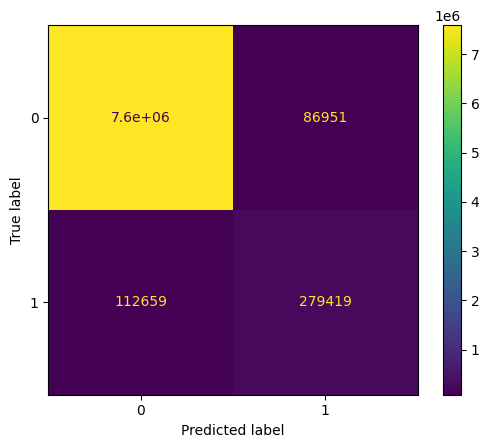

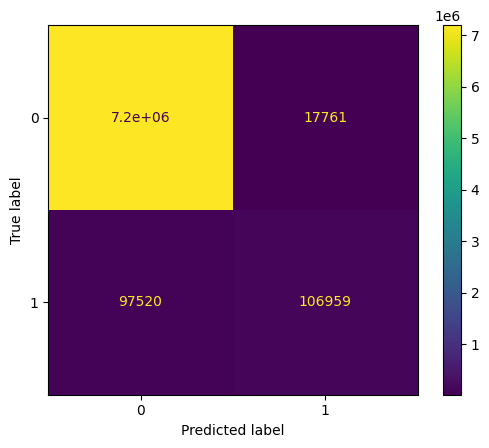

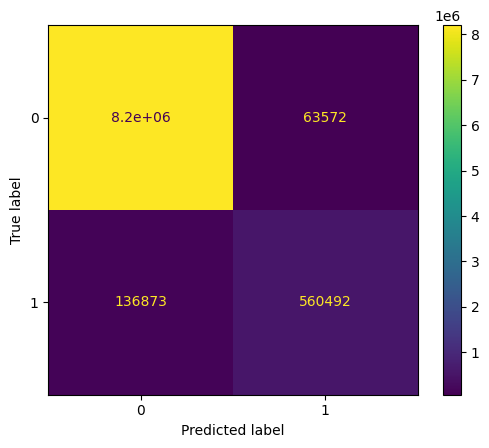

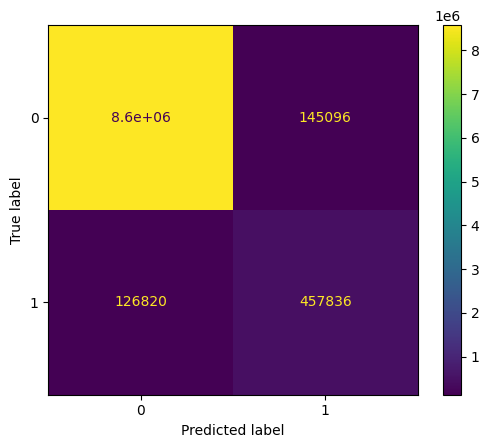

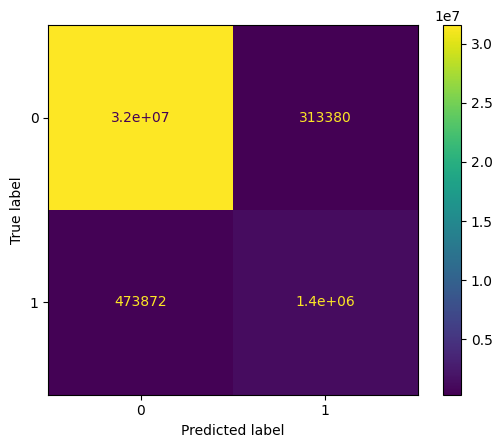

In [62]:
GetRawMetricsAndCM(all_preds_unet_test_right_order, test_labels)

=============Record 0================
accuracy 0.9752530986613783
precision 0.7636540516839768
recall 0.7107386795484572
f1 score 0.7362468097248569
=============Record 1================
accuracy 0.9844524258760108
precision 0.858321538857437
recall 0.5219802522508424
f1 score 0.649172371218042
=============Record 2================
accuracy 0.9775362561356538
precision 0.8983794950218627
recall 0.801963103969944
f1 score 0.847437697318028
=============Record 3================
accuracy 0.9707581650193382
precision 0.760092026429298
recall 0.7809464026709724
f1 score 0.7703781067749438
===========ALL RECORDS SCORE==================
Full accuracy 0.976641913507109
Mean accuracy 0.9769999864230953
Mean precision 0.8201117779981437
Mean recall 0.703907109610054
Mean f1 0.7508087462589677
Full Confusion Matrix


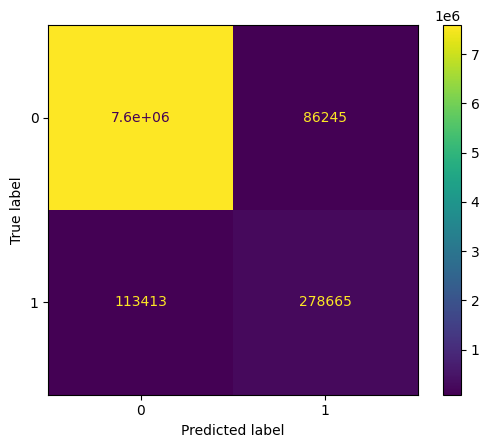

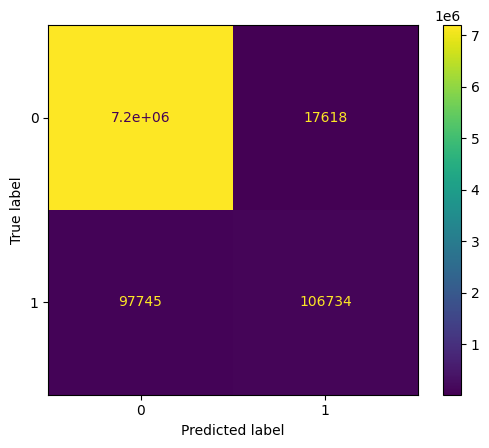

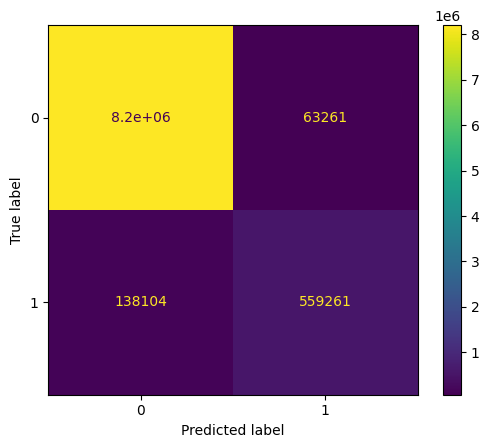

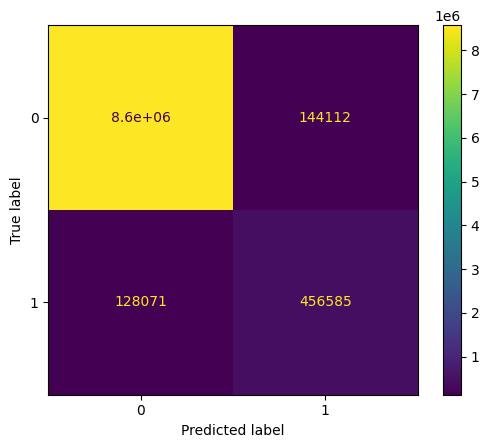

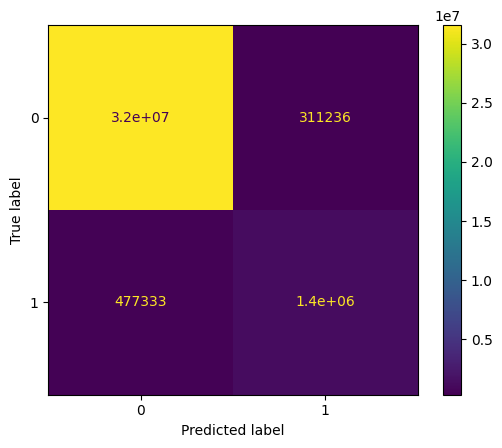

In [108]:
GetRawMetricsAndCM(all_preds_unet_test_right_order, test_labels)

##### SEED 520 overlap

In [64]:
OVERLAP = 520
test_labels_overlap = [labels[:, OVERLAP:] for labels in test_labels]

##### Postprocessed

=============Record 0================
accuracy 0.9754328210213188
precision 0.8212746917672014
recall 0.6320043460739955
f1 score 0.7143145411200378
=============Record 1================
accuracy 0.9824532345013477
precision 0.8587531875434665
recall 0.43478792443233777
f1 score 0.5772920745307737
=============Record 2================
accuracy 0.9756954241071428
precision 0.8982667446155481
recall 0.7755622952112595
f1 score 0.8324169333781721
=============Record 3================
accuracy 0.9717769660507091
precision 0.7624766836674798
recall 0.7998378533701869
f1 score 0.7807105412534642
===========ALL RECORDS SCORE==================
Full accuracy 0.9760376229411067
Mean accuracy 0.9763396114201296
Mean precision 0.835192826898424
Mean recall 0.6605481047719449
Mean f1 0.7261835225706119
Full Confusion Matrix


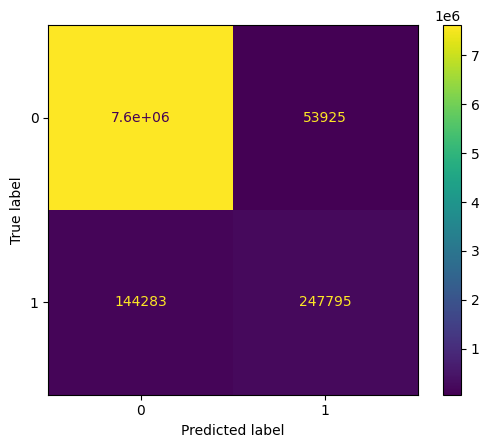

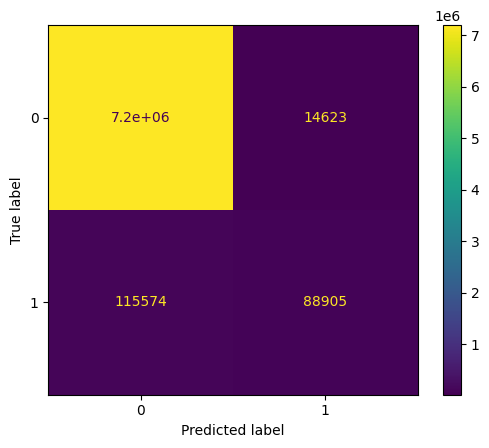

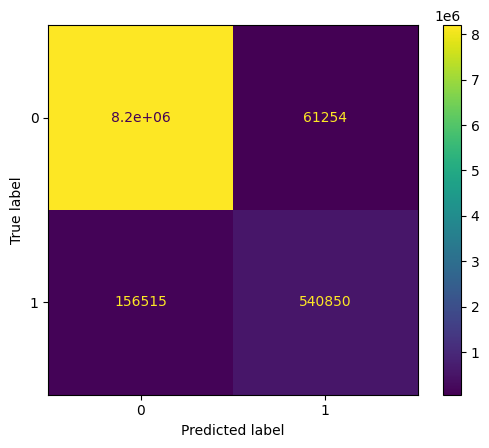

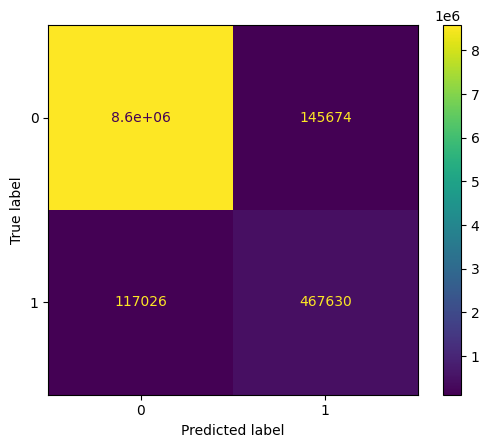

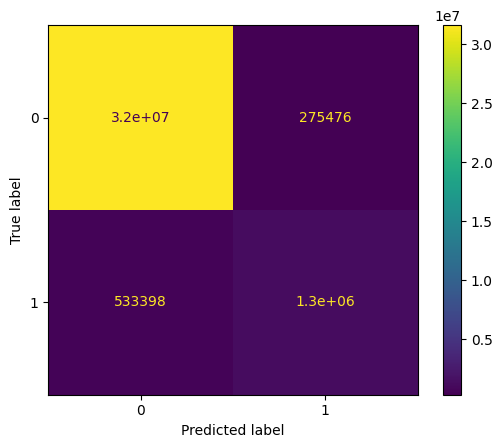

In [65]:
GetRawMetricsAndCM(all_preds_seed_test_right_order, test_labels_overlap)

=============Record 0================
accuracy 0.9754258800198314
precision 0.8211904067455057
recall 0.6319227296609348
f1 score 0.7142305308522752
=============Record 1================
accuracy 0.9824467654986523
precision 0.8583275409329626
recall 0.4348074863433409
f1 score 0.5772131025147453
=============Record 2================
accuracy 0.97570703125
precision 0.8983689875099654
recall 0.7756196539832082
f1 score 0.8324938723839793
=============Record 3================
accuracy 0.9717739578856898
precision 0.7625120684706312
recall 0.7996975999562136
f1 score 0.7806622675785424
===========ALL RECORDS SCORE==================
Full accuracy 0.9760367934589407
Mean accuracy 0.9763384086635434
Mean precision 0.8350997509147662
Mean recall 0.6605118674859244
Mean f1 0.7261499433323856
Full Confusion Matrix


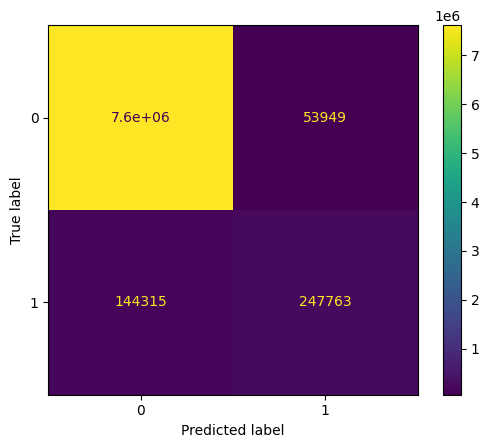

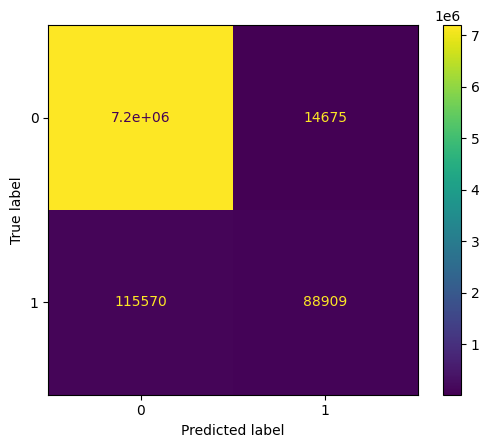

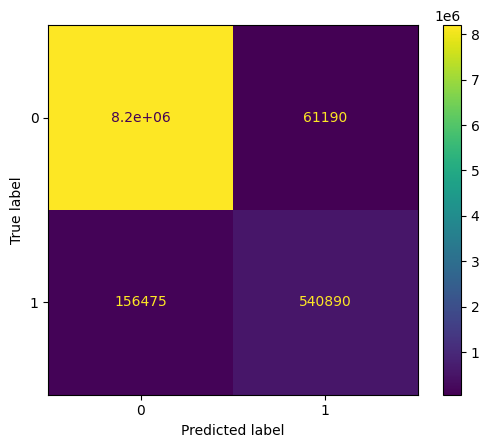

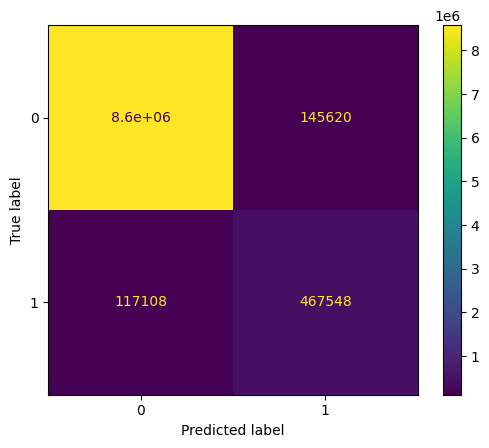

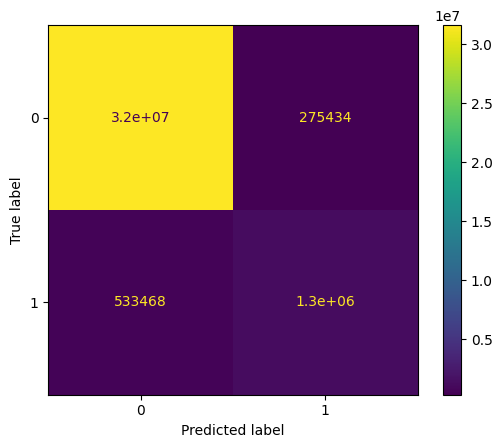

In [116]:
GetRawMetricsAndCM(all_preds_seed_test_right_order, test_labels_overlap)

#### Ensemble Short


=============Record 0================
accuracy 0.976039234060698
precision 0.8343307330299086
recall 0.6325884135299609
f1 score 0.7195869738348099
=============Record 1================
accuracy 0.9829105274224069
precision 0.8917735818607279
recall 0.432386699856709
f1 score 0.5823932969504946
=============Record 2================
accuracy 0.9765112723214285
precision 0.926331163031791
recall 0.7585324758196927
f1 score 0.8340761285612583
=============Record 3================
accuracy 0.973410848049096
precision 0.801633507478709
recall 0.7663463643578446
f1 score 0.7835928700847167
===========ALL RECORDS SCORE==================
Full accuracy 0.9769501434477953
Mean accuracy 0.9772179704634074
Mean precision 0.8635172463502842
Mean recall 0.6474634883910518
Mean f1 0.7299123173578199
Full Confusion Matrix


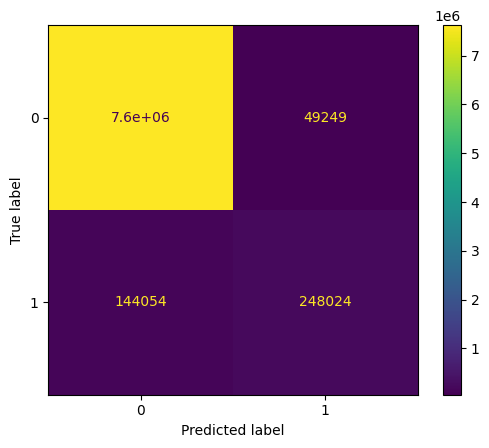

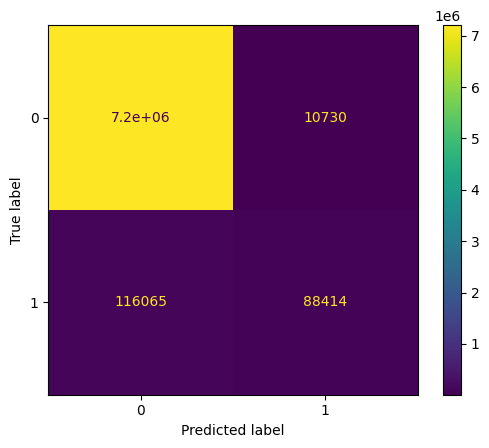

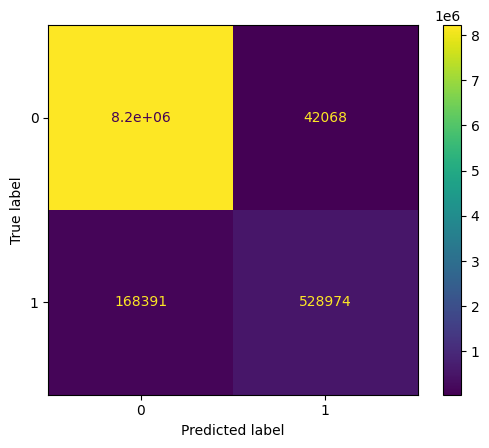

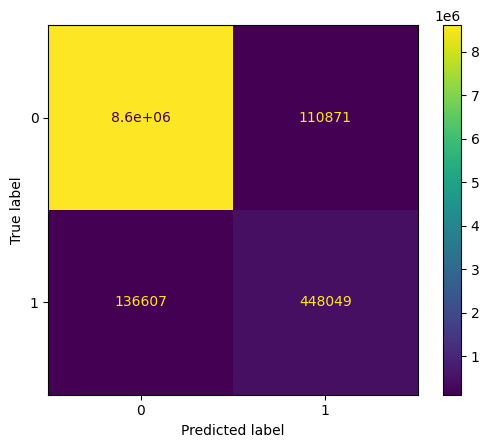

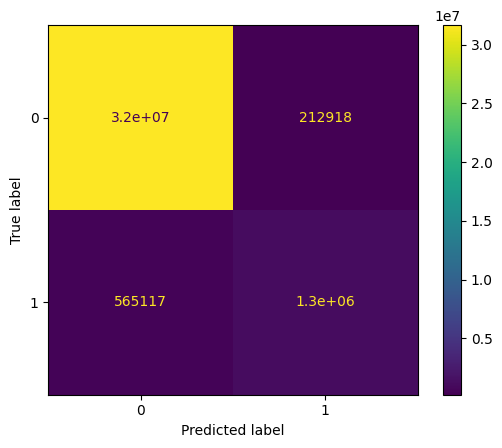

In [39]:
GetRawMetricsAndCM(all_preds, ensemble_test_labels)

#### Ensemble

=============Record 0================
accuracy 0.9759173868419878
precision 0.8045952938277688
recall 0.6662857900723835
f1 score 0.7289378004849615
=============Record 1================
accuracy 0.9831353410212036
precision 0.8547123929407978
recall 0.4675443444070051
f1 score 0.6044453155377403
=============Record 2================
accuracy 0.9767375
precision 0.8916207310294229
recall 0.7981301040344726
f1 score 0.8422890902597442
=============Record 3================
accuracy 0.9717417603905676
precision 0.754294198661339
recall 0.8159208149749596
f1 score 0.7838981693053615
===========ALL RECORDS SCORE==================
Full accuracy 0.976570252683795
Mean accuracy 0.9768829970634397
Mean precision 0.8263056541148321
Mean recall 0.6869702633722052
Mean f1 0.7398925938969518
Full Confusion Matrix


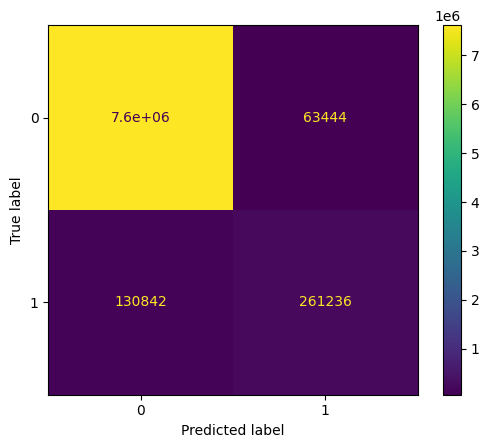

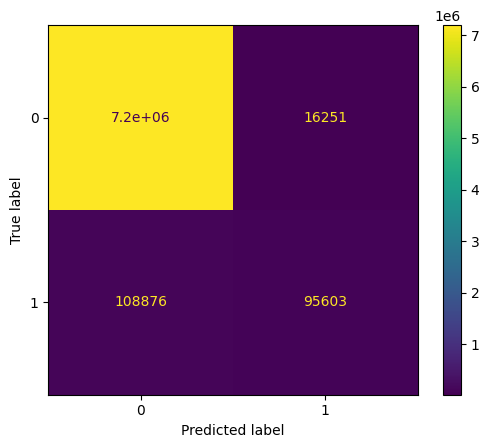

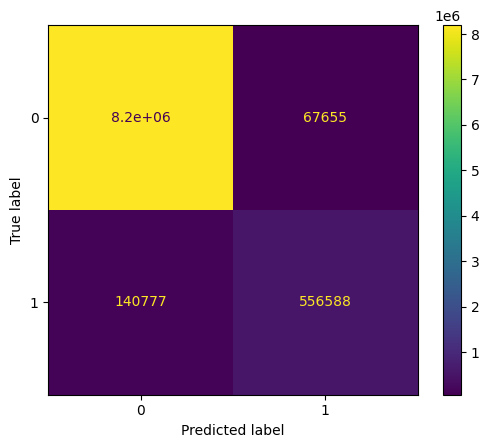

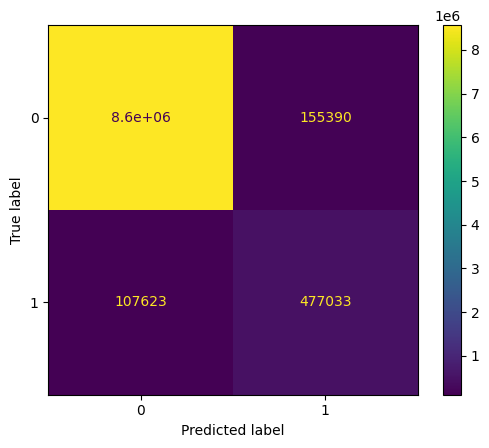

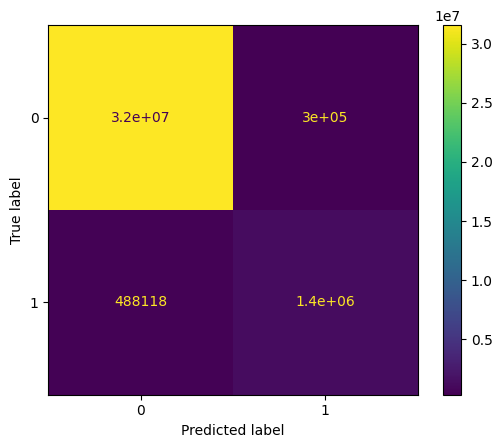

In [74]:
GetRawMetricsAndCM(all_preds, ensemble_test_labels)

=============Record 0================
accuracy 0.9759085860764452
precision 0.8046895948074203
recall 0.6659185162136105
f1 score 0.7287566238359006
=============Record 1================
accuracy 0.9831318367324934
precision 0.8547230221618044
recall 0.46738295864122964
f1 score 0.6043130894455457
=============Record 2================
accuracy 0.9767375
precision 0.8917952128725168
recall 0.7979307823019509
f1 score 0.8422559088191444
=============Record 3================
accuracy 0.9717323056294507
precision 0.7543203334466968
recall 0.8156420185545005
f1 score 0.7837835838864733
===========ALL RECORDS SCORE==================
Full accuracy 0.9765647719233381
Mean accuracy 0.9768775571095973
Mean precision 0.8263820408221096
Mean recall 0.6867185689278229
Mean f1 0.7397773014967659
Full Confusion Matrix


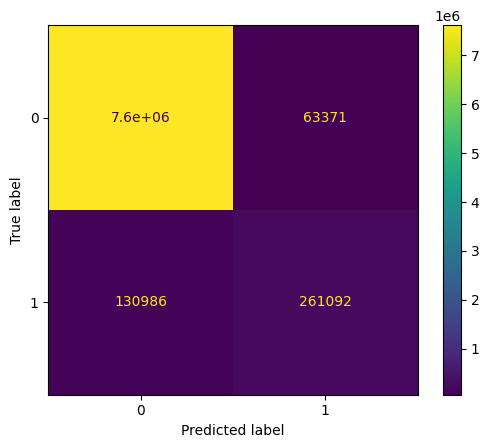

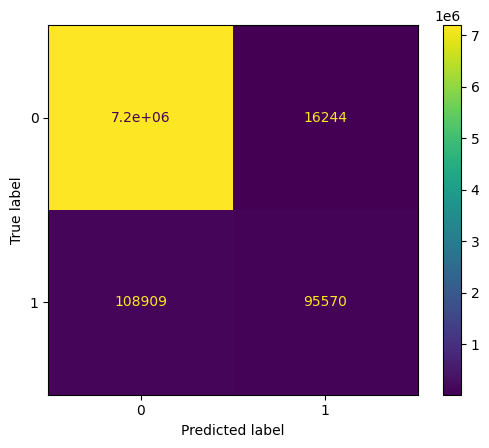

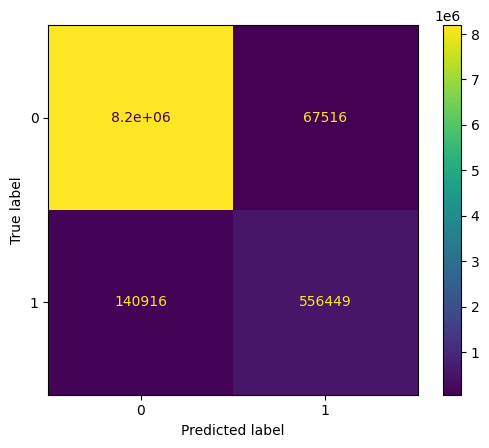

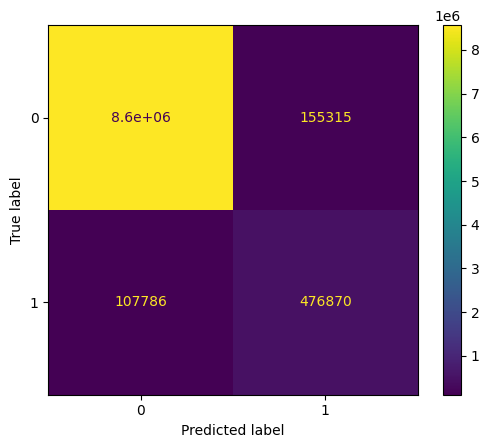

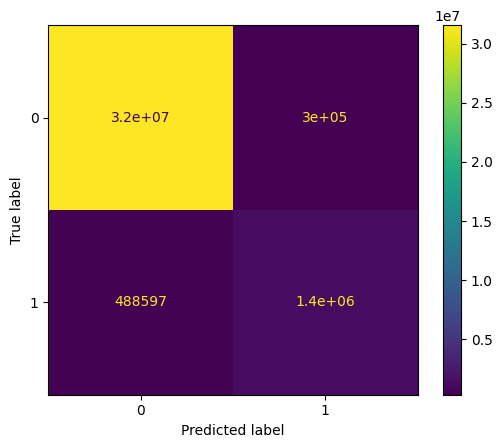

In [29]:
GetRawMetricsAndCM(all_preds, ensemble_test_labels)

#### EpiSpike

In [30]:
def CollectingTPFPFN(pred_labels, true_labels):
    i = 0
    TP = 0
    FP = 0
    FN = 0

    is_true_flag = 0
    is_pred_flag = 0
    while i < len(pred_labels):
        while true_labels[i] == 1:
            is_true_flag = 1
            if pred_labels[i] == 1:
                is_pred_flag = 1
            i += 1
        if is_true_flag:
            if is_pred_flag:
                TP += 1
            else:
                FN += 1
        
        is_true_flag = 0
        is_pred_flag = 0   
        i += 1

    i = 0
    while i < len(pred_labels):
        while pred_labels[i] == 1:
            is_pred_flag = 1
            if true_labels[i] == 1:
                is_true_flag = 1
            i += 1
        if is_pred_flag and not is_true_flag:
            FP += 1
        is_pred_flag = 0
        is_true_flag = 0
        i += 1

    return TP, FP, FN              

In [31]:
def GetRawMetricsAndCMEPI(predictions, test_labels):
    lens = []
    sums = []

    acc = []
    precision = []
    recall = []
    f1 = []

    TP_sum = 0
    FP_sum = 0
    FN_sum = 0
    
    all_cm = 0
    for i in range(len(test_labels)):
        pred_len = len(predictions[i])

        TP, FP, FN = CollectingTPFPFN(predictions[i], test_labels[i][1, :pred_len].numpy())

        TP_sum += TP
        FP_sum += FP
        FN_sum += FN
            

        precision.append(TP / (TP + FP))
        recall.append(TP / (TP + FN))
        f1.append(2 * TP / (2 * TP + FP + FN))
        

        cm = np.array([[0, FP], [FN, TP]])
        all_cm += cm
        print("=============Record " + str(i) + "================")
    
        print("precision", precision[i])
        print("recall", recall[i])
        print("f1 score", f1[i])
        
        ConfusionMatrixDisplay(cm).plot()
    print("===========ALL RECORDS SCORE==================")
    
    
    print("Full precision", TP_sum / (TP_sum + FP_sum))
    print("Full recall", TP_sum / (TP_sum + FN_sum))
    print("Full f1", 2 * TP_sum / (2 * TP_sum + FP_sum + FN_sum))   
    

    print("Full Confusion Matrix")
    ConfusionMatrixDisplay(all_cm).plot()

##### Unet

##### Postprocessed

=============Record 0================
precision 0.7805243445692884
recall 0.8362760834670947
f1 score 0.8074389771406432
=============Record 1================
precision 0.8933566433566433
recall 0.6033057851239669
f1 score 0.7202255109231853
=============Record 2================
precision 0.9354078264969354
recall 0.8920863309352518
f1 score 0.9132336018411967
=============Record 3================
precision 0.7579122709605774
recall 0.931740614334471
f1 score 0.8358848744641764
===========ALL RECORDS SCORE==================
Full precision 0.8409675759135358
Full recall 0.8478035281909374
Full f1 0.8443717164757557
Full Confusion Matrix


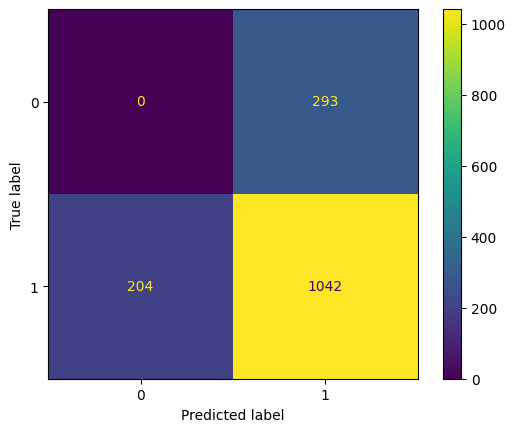

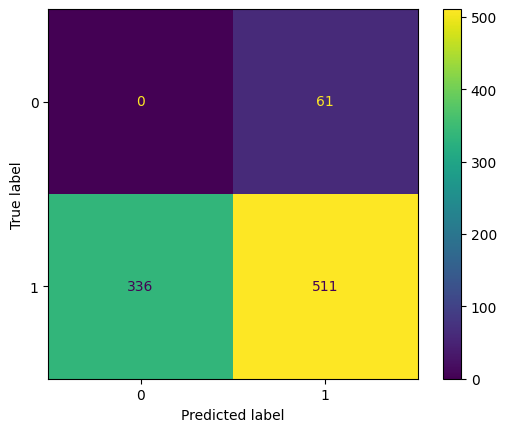

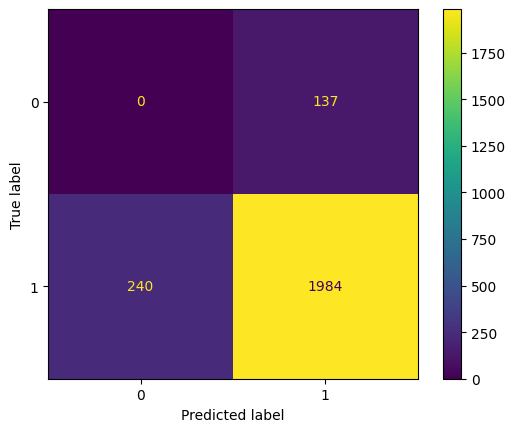

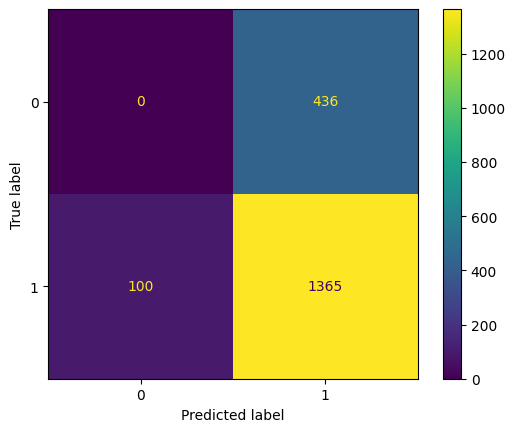

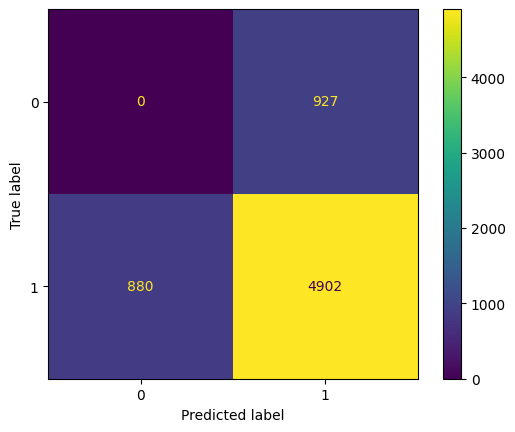

In [66]:
GetRawMetricsAndCMEPI(all_preds_unet_test_right_order, test_labels)

=============Record 0================
precision 0.6961690885072656
recall 0.8459069020866774
f1 score 0.763768115942029
=============Record 1================
precision 0.85
recall 0.6221959858323495
f1 score 0.7184730743012951
=============Record 2================
precision 0.8866253321523472
recall 0.9001798561151079
f1 score 0.893351182507809
=============Record 3================
precision 0.6755424063116371
recall 0.9351535836177475
f1 score 0.7844259948468365
===========ALL RECORDS SCORE==================
Full precision 0.7714953271028038
Full recall 0.8566240055344172
Full f1 0.811834125553188
Full Confusion Matrix


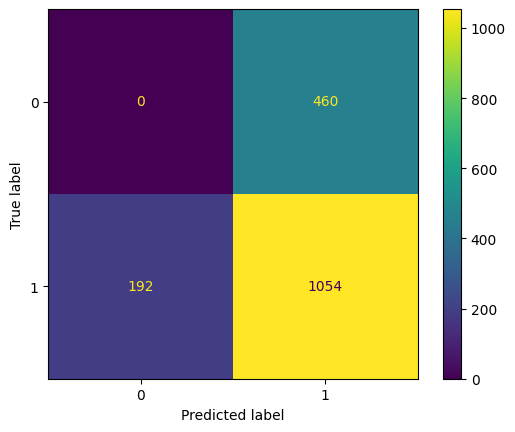

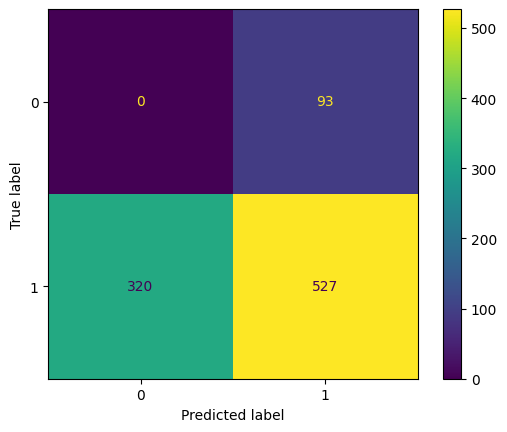

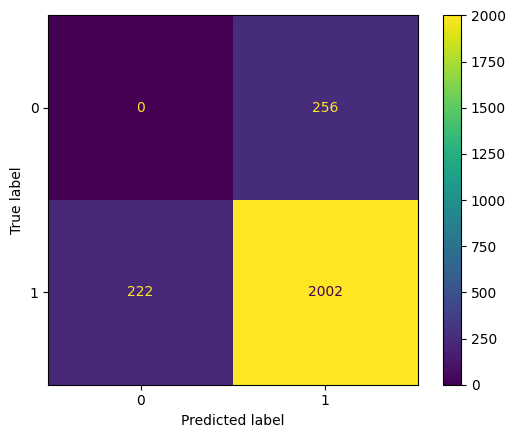

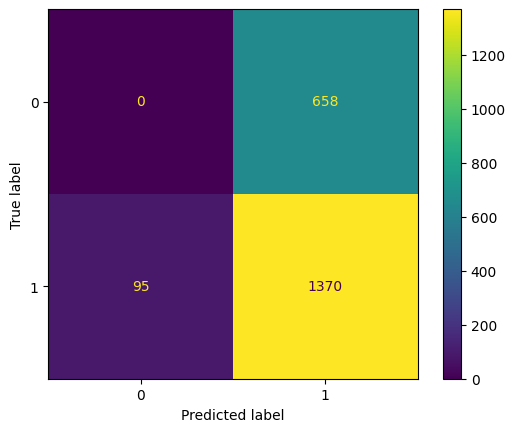

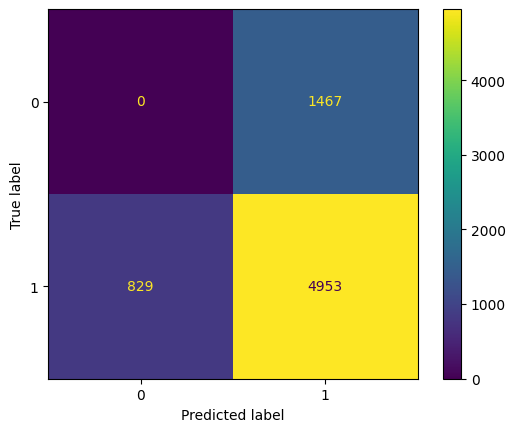

In [121]:
GetRawMetricsAndCMEPI(all_preds_unet_test_right_order, test_labels)

##### SEED 520 overlap

##### Postprocessed

=============Record 0================
precision 0.8486281929990539
recall 0.7199036918138042
f1 score 0.7789839339991316
=============Record 1================
precision 0.9066666666666666
recall 0.4817001180637544
f1 score 0.6291441788743254
=============Record 2================
precision 0.954639175257732
recall 0.8327338129496403
f1 score 0.8895292987512008
=============Record 3================
precision 0.8131067961165048
recall 0.9146757679180887
f1 score 0.8609058785737231
===========ALL RECORDS SCORE==================
Full precision 0.8826300294406281
Full recall 0.7777585610515393
Full f1 0.8268824124298979
Full Confusion Matrix


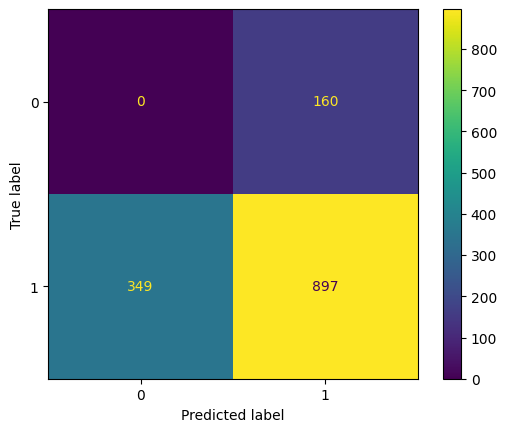

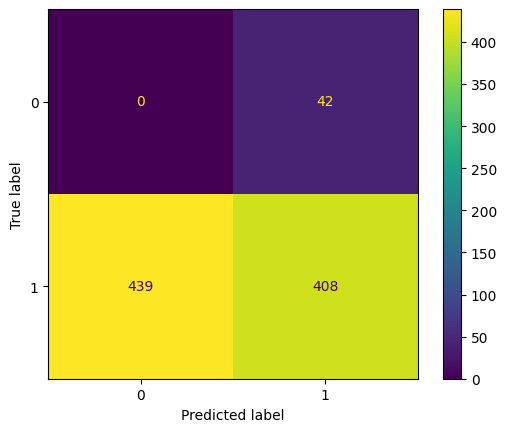

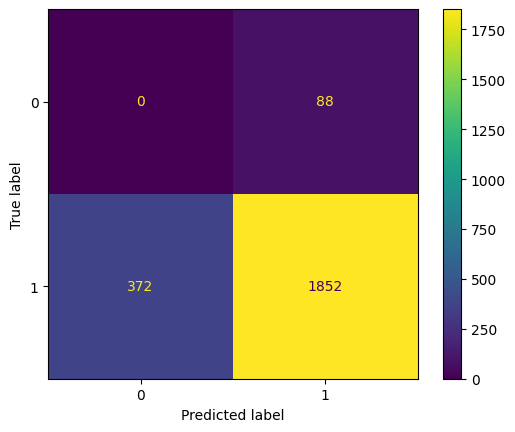

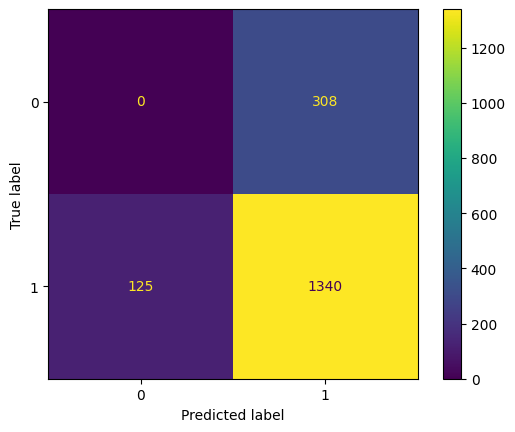

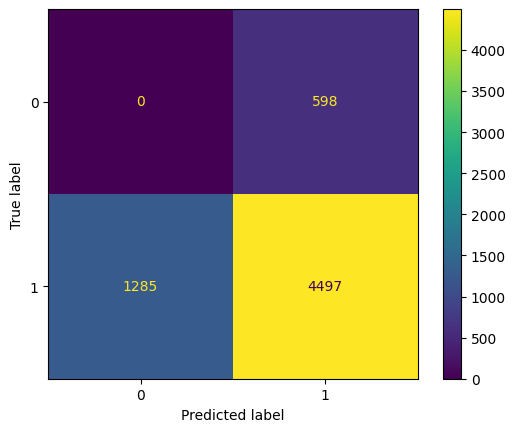

In [67]:
GetRawMetricsAndCMEPI(all_preds_seed_test_right_order, test_labels_overlap)

=============Record 0================
precision 0.8387698042870456
recall 0.7223113964686998
f1 score 0.7761966364812419
=============Record 1================
precision 0.9010989010989011
recall 0.48406139315230223
f1 score 0.6298003072196621
=============Record 2================
precision 0.9493606138107417
recall 0.8345323741007195
f1 score 0.8882507776980139
=============Record 3================
precision 0.7996422182468694
recall 0.9153583617747441
f1 score 0.8535964353914705
===========ALL RECORDS SCORE==================
Full precision 0.8734496124031008
Full recall 0.7794880664130058
Full f1 0.8237982087369767
Full Confusion Matrix


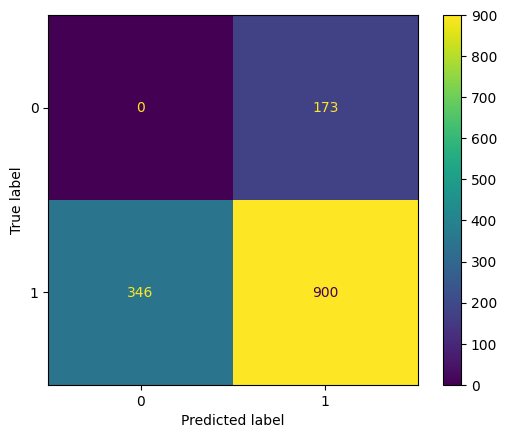

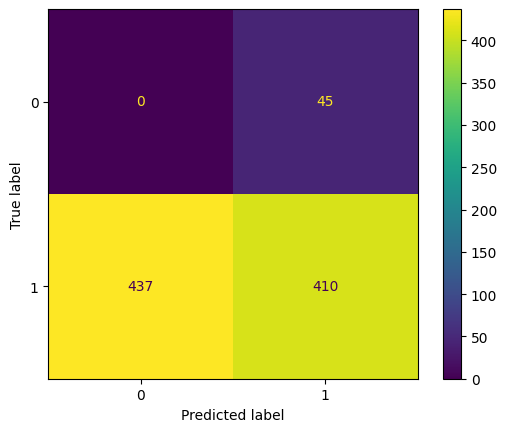

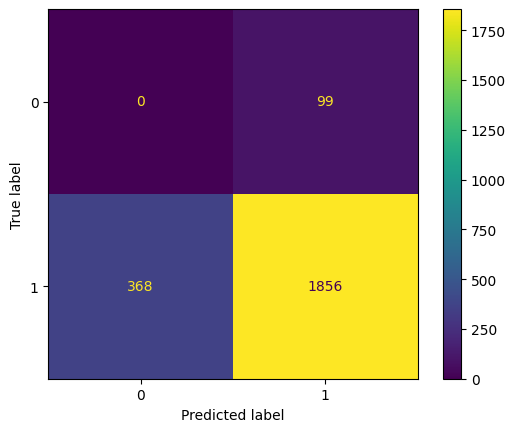

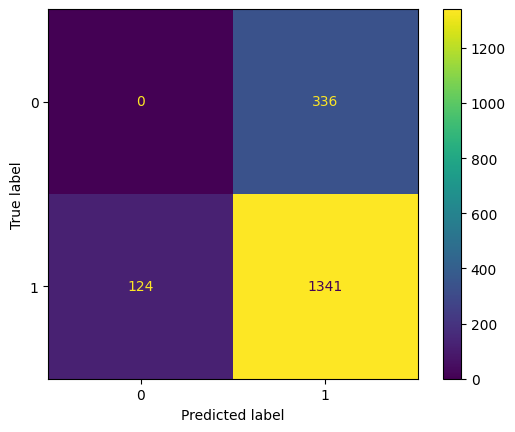

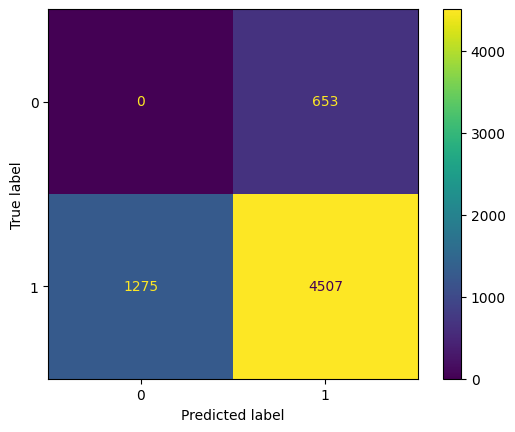

In [122]:
GetRawMetricsAndCMEPI(all_preds_seed_test_right_order, test_labels_overlap)

#### Ensemble Short

=============Record 0================
precision 0.8532961931290622
recall 0.7375601926163724
f1 score 0.7912182522600086
=============Record 1================
precision 0.9261744966442953
recall 0.4887839433293979
f1 score 0.6398763523956723
=============Record 2================
precision 0.9643595041322314
recall 0.8394784172661871
f1 score 0.8975961538461539
=============Record 3================
precision 0.8272445820433436
recall 0.9119453924914676
f1 score 0.8675324675324675
===========ALL RECORDS SCORE==================
Full precision 0.8937931034482759
Full recall 0.784503631961259
Full f1 0.8355899419729207
Full Confusion Matrix


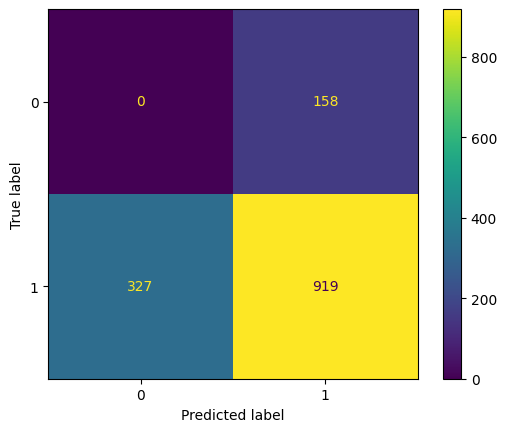

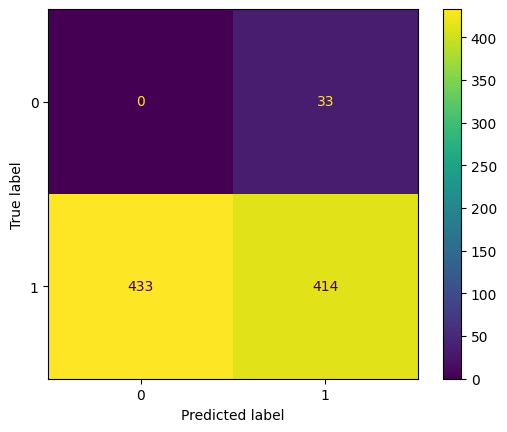

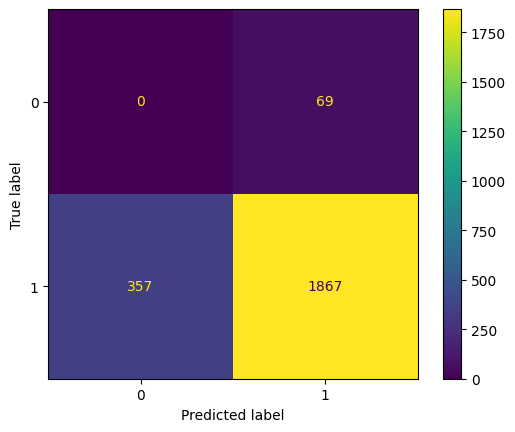

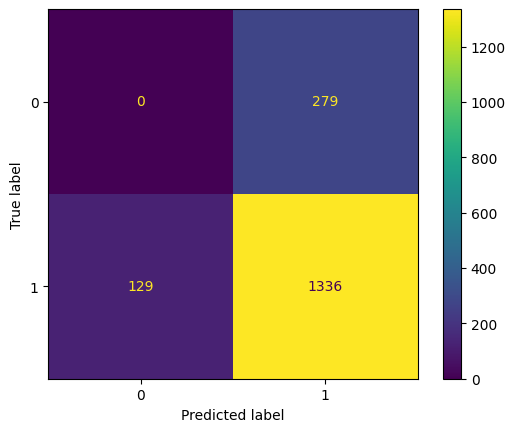

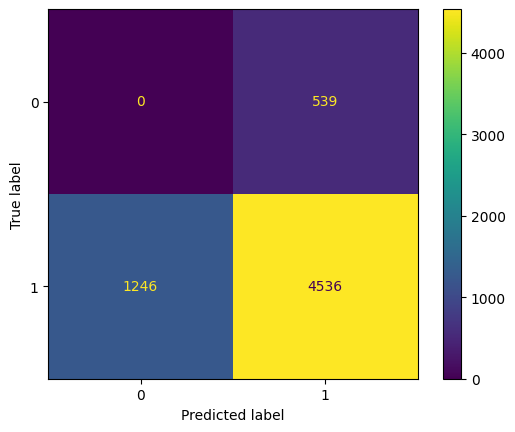

In [40]:
GetRawMetricsAndCMEPI(all_preds, ensemble_test_labels)

#### Ensemble

=============Record 0================
precision 0.830255057167986
recall 0.7576243980738363
f1 score 0.7922786403692824
=============Record 1================
precision 0.9094736842105263
recall 0.5100354191263282
f1 score 0.653555219364599
=============Record 2================
precision 0.9478957915831663
recall 0.8507194244604317
f1 score 0.8966824644549763
=============Record 3================
precision 0.7984678845020624
recall 0.9249146757679181
f1 score 0.8570524984187223
===========ALL RECORDS SCORE==================
Full precision 0.8714420358152686
Full recall 0.7995503286060187
Full f1 0.8339496707856048
Full Confusion Matrix


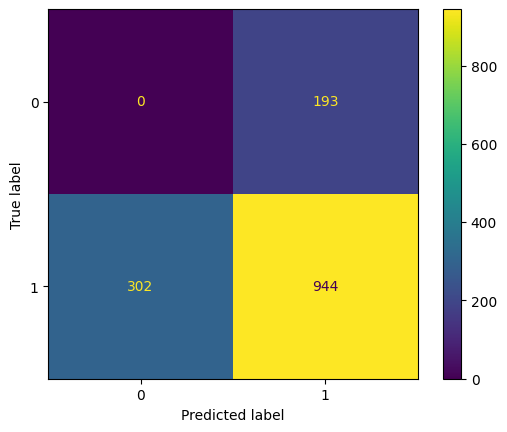

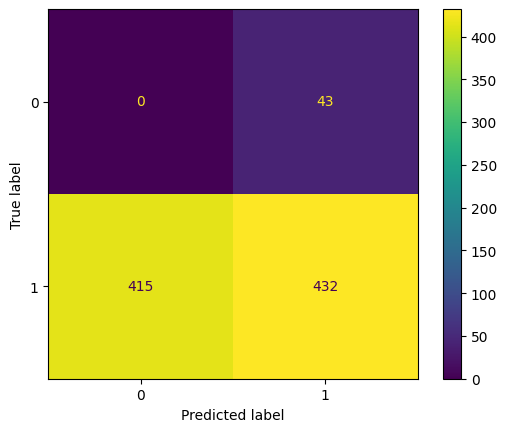

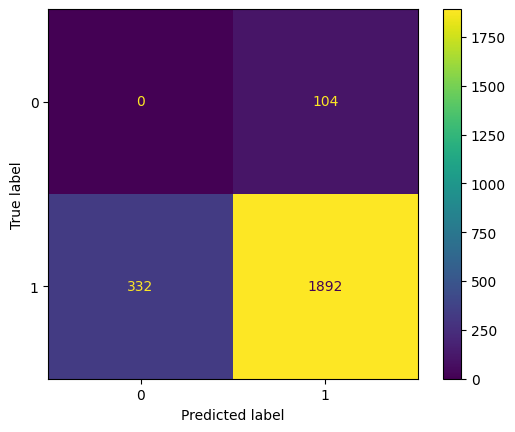

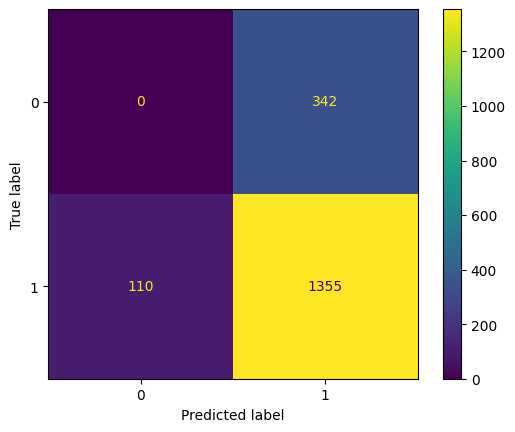

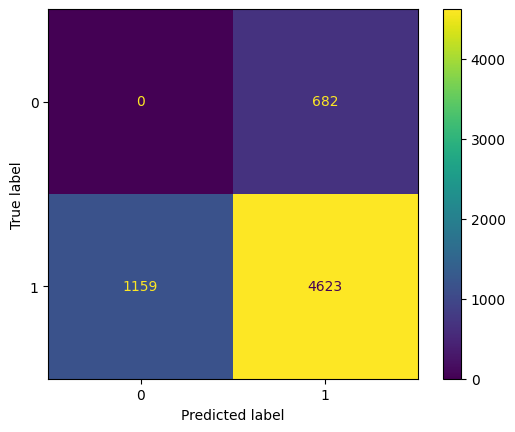

In [75]:
GetRawMetricsAndCMEPI(all_preds, ensemble_test_labels)

=============Record 0================
precision 0.8114824335904027
recall 0.7600321027287319
f1 score 0.7849150435142975
=============Record 1================
precision 0.8913934426229508
recall 0.51357733175915
f1 score 0.651685393258427
=============Record 2================
precision 0.9363277393879565
recall 0.8529676258992805
f1 score 0.8927058823529411
=============Record 3================
precision 0.7775229357798165
recall 0.9255972696245733
f1 score 0.8451230913057027
===========ALL RECORDS SCORE==================
Full precision 0.8543778801843318
Full recall 0.8016257350397786
Full f1 0.8271615954314268
Full Confusion Matrix


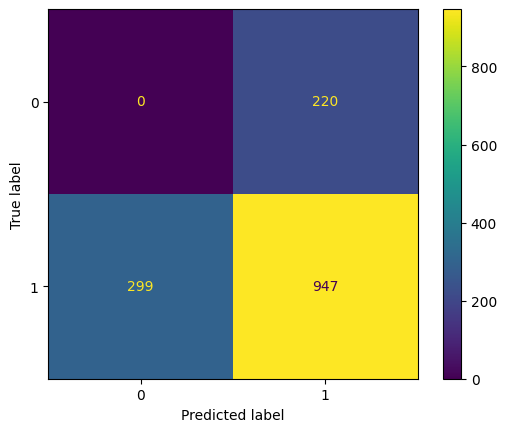

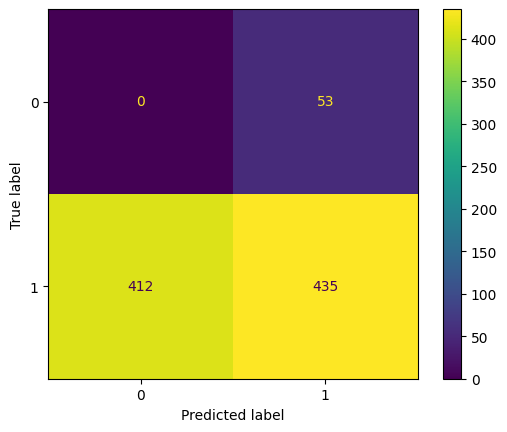

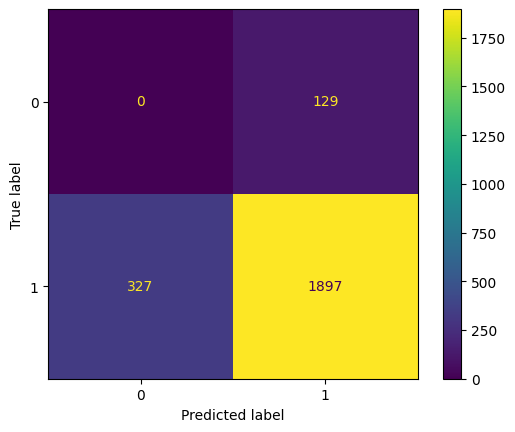

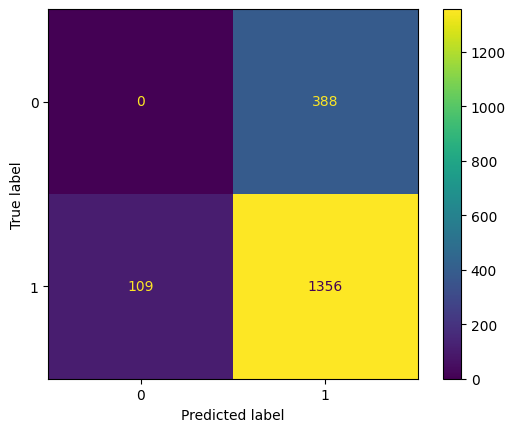

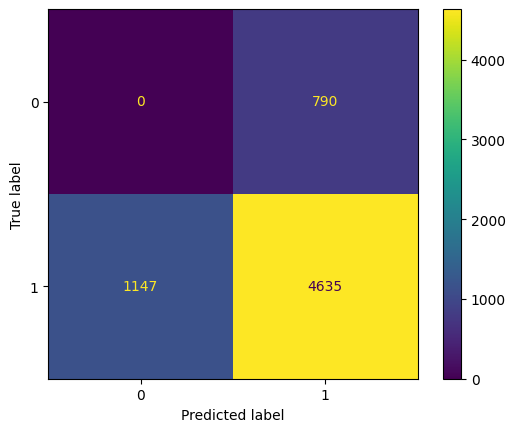

In [32]:
GetRawMetricsAndCMEPI(all_preds, ensemble_test_labels)

### EDF wtire

In [29]:
def CreateNewAnnotation(time_start, labels, freq): 
    freq = 1/freq
    i = 0
    label_starts = [time_start]
    label_lens = [-1]
    desc = ["StartPredictionTime"]
    while i < len(labels):
        if labels[i] == 1:
            desc.append("ModelPrediction")
            label_starts.append(time_start + i*freq)
            cur_start = i
            while labels[i] == 1:
                i += 1
            label_lens.append((i - cur_start) * freq)
        i += 1
    label_starts += [time_start + i*freq]
    label_lens += [-1]
    desc += ["EndPredictionTime"]

    return np.array(label_starts), np.array(label_lens), np.array(desc)

In [34]:
IDS_TEST

[2, 6, 12, 13]

In [50]:
def WriteEDF(predictions, test_idx):
    freq = 256
    time_start = 0
    for i, idx in enumerate(test_idx):
        preds_annotations = CreateNewAnnotation(time_start, predictions[i], freq)
        suffics = str(idx)
        if idx < 10:
            suffics = "0" + str(idx)
        data = mne.io.read_raw_edf("data/01-02-00" + suffics + " PSG.edfWithLabels.edf")

        preds_annotations = list(preds_annotations)
        preds_annotations[1] = np.clip(preds_annotations[1], a_min=0, a_max = None)

        old_annot = np.array([[data.annotations[i]["onset"], data.annotations[i]["duration"], data.annotations[i]["description"]] 
                      for i in range(len(data.annotations))])
        full_annot = np.concatenate([np.array(preds_annotations), old_annot.T], axis=1)
        annotations = mne.Annotations(full_annot[0], full_annot[1], full_annot[2])
        data.set_annotations(annotations)
        
        data.export("predicts/01-02-00" + suffics + " PSG.edfWithLabelsSEED4000.edf", overwrite=True)
        data.close()
        

In [51]:
WriteEDF(all_preds, IDS_TEST)

Extracting EDF parameters from /home/gromov_n/extreme-events/EEG seizure/Sleep Spindles/data/01-02-0013 PSG.edfWithLabels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Overwriting existing file.
Reading 0 ... 9311231  =      0.000 ... 36371.996 secs...
Extracting EDF parameters from /home/gromov_n/extreme-events/EEG seizure/Sleep Spindles/data/01-02-0012 PSG.edfWithLabels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Overwriting existing file.
Reading 0 ... 8071679  =      0.000 ... 31529.996 secs...
Extracting EDF parameters from /home/gromov_n/extreme-events/EEG seizure/Sleep Spindles/data/01-02-0002 PSG.edfWithLabels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Overwriting existing file.
Reading 0 ... 8964095  =      0.000 ... 35015.996 secs...
Extracting EDF parameters from /home/gromov_n/extreme-events/EEG seizure/Sleep Spindles/data/01-02-0006 PSG.e